In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


In [2]:
with gzip.open('mnist.pkl.gz') as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

In [3]:
def dense_layer(x, shape, activation=True, next_shape=1):
    dense = nengo.Dense( shape, init=np.ones((x.size_out,1)) )

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(next_shape, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=dense.size_out)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=np.ones((next_shape,dense.size_out)) )

    # print out the shape information for our new layer
    print("LAYER")
    print(dense.size_out, "->", dense.size_out)

    return layer, dense

In [8]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28*28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as model:
    # set up the default parameters for ensembles/connections
    #nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = (
        nengo.SpikingRectifiedLinear(amplitude=amp))
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    input = nengo.Node(
        nengo.processes.PresentInput(train_data[0], presentation_time),
        size_out=28 * 28 )

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=28 * 28)

    # build parallel copies of the network
    for _ in range(n_parallel):
        encoded, dense = dense_layer(input, (784,1), next_shape=32)
        encoded, dense = dense_layer(encoded, (32,1), next_shape=784)
        decoded, dense = dense_layer(encoded, (784,1),next_shape=784)
        nengo.Connection(decoded, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out)
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01))

LAYER
784 -> 784
LAYER
32 -> 32
LAYER
784 -> 784
LAYER
784 -> 784
LAYER
32 -> 32
LAYER
784 -> 784


In [9]:
# set up training data
minibatch_size = 200
#x_train  = {inp: train_data[0][:, None, :],
#            A_spikes: train_data[1][:, None, :]}
x_train  = {input: train_data[0][:, None, :],
            out_p: train_data[0][:, None, :]}

In [10]:
x_test = {
    input: np.tile(test_data[0][:, None, :],
                 (1, int(presentation_time / dt), 1)),
    out_p_filt: np.tile(test_data[0][:, None, :],
                        (1, int(presentation_time / dt), 1))
}

In [7]:
def binary_crossentropy(outputs, targets):
    print(type(outputs), flush=True)
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(
        target=targets, output=outputs))

In [11]:
do_training = True #False

with nengo_dl.Simulator(model, minibatch_size=minibatch_size, seed=0) as sim:
    if do_training:
        
        # run training
        sim.train(x_train, tf.train.AdamOptimizer(learning_rate=0.001),
                  objective={out_p: binary_crossentropy}, n_epochs=5)

        sim.save_params("./mnist_params")
    # store trained parameters back into the network
    sim.freeze_params(model)

Build finished in 0:00:00                                                      
|#                         Optimizing graph                           | 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Construction finished in 0:00:01                                               ##################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)<class 'tensorflow.python.framework.ops.Tensor'>
|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:529: UserWarning: Training for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Training for one timestep, but the network contains "


|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


|#################Training (99%)################# | ETA: 0:00:07 (loss: 2.1213)WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Training finished in 2:41:22 (loss: 2.1922)                                    


In [12]:
n_presentations = 50
with nengo_dl.Simulator(model, dt=dt) as sim:
    # run the simulation on Loihi
    sim.run(n_presentations * presentation_time)

    # check classification error
    step = int(presentation_time / dt)
    output = sim.data[out_p][step - 1::step]
    #correct = 100 * (np.mean(
    #    np.argmax(output, axis=-1)
    #    != np.argmax(x_test[out_p][:n_presentations, -1],
    #                 axis=-1)
    #))
    #print("Error: %.2f%%" % correct)

Build finished in 0:00:00                                                      
|#                Optimizing graph: creating signals                  | 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               ##################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
Simulation finished in 0:02:19                                                 


In [16]:
array = np.array(output)

In [17]:
array.shape

(50, 784)

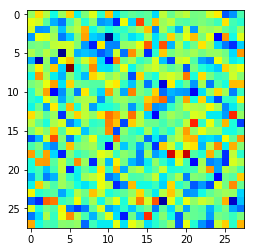

In [18]:
a = array[0]
plt.imshow(a.reshape(28,28), cmap='jet')
plt.show()

In [24]:
test_data[0][:, None, :].shape
#plt.imshow(test_data[0])

(10000, 1, 784)

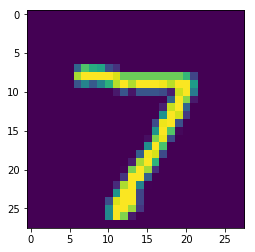

In [25]:
cc = test_data[0][:, None, :]
plt.imshow(cc[0].reshape(28,28))

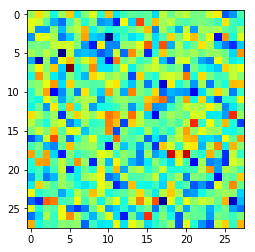

In [27]:
a = array[31]
plt.imshow(a.reshape(28,28), cmap='jet')
plt.show()